In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

### Data Awal
Data berasal dari dataset DARPA 2000. DDoS attack terjadi pada 2 jam 6 menit 15 detik setelah trafik mulai direkam

In [2]:
df = pd.read_csv("../data/darpa2000-all.csv")
del df["Info"]
del df["Length"]
df.head()

,No.,Time,Source,Destination,Protocol
0,1,0.000000,172.16.113.168,172.16.112.50,TELNET
1,2,0.000426,172.16.112.50,172.16.113.168,TELNET
2,3,0.019849,172.16.113.168,172.16.112.50,TCP
3,4,0.530125,172.16.113.168,172.16.112.50,TELNET
4,5,0.530634,172.16.112.50,172.16.113.168,TELNET


In [3]:
#df.info()

df["T"] = pd.to_timedelta(df["Time"], unit='s')
df = df.set_index("T")


In [4]:
# hitung source unique
unique_source_count = df[['Source']].resample('3s').nunique()

# Hitung dest unique
unique_destination_count = df[['Destination']].resample('3s').nunique()

# Hitung proto unique
unique_protocol_count = df[['Protocol']].resample('3s').nunique()

# Hitung jumlah packet
packets_count = df[['No.']].resample('3s').count()

### Parameter Algoritma
 - A1 = Number of packets
 - A2 = Number of Unique Source IP
 - A3 = (A2) divided by (Number of Unique Dest. IP)
 - A4 = (A2) divided by (Number of Unique Protocol)
 - Beta
 - T = time interval (resampling)
 - K = Window Size

In [5]:
df[['Source']].resample('3s').nunique().to_csv('USIP.csv')
df[['Destination']].resample('3s').nunique().to_csv('UDIP.csv')
df[['Protocol']].resample('3s').nunique().to_csv('UPR.csv')
df[['No.']].resample('3s').nunique().to_csv('Packets.csv')

### Plot Data setelah resampling

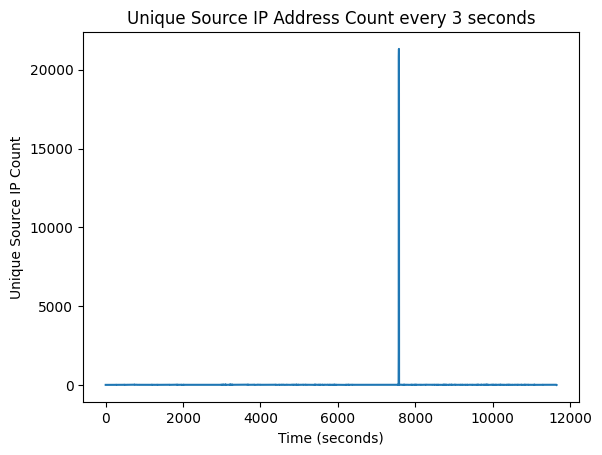

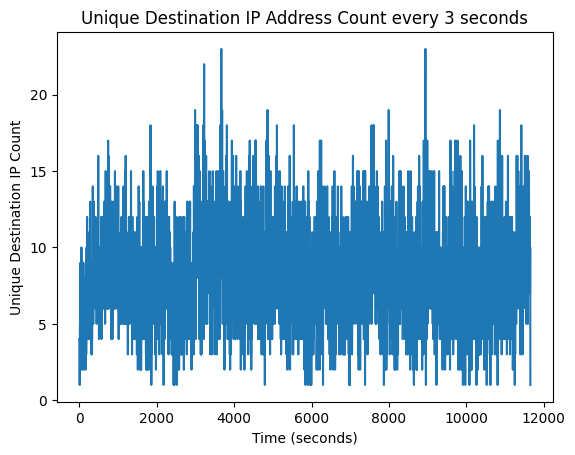

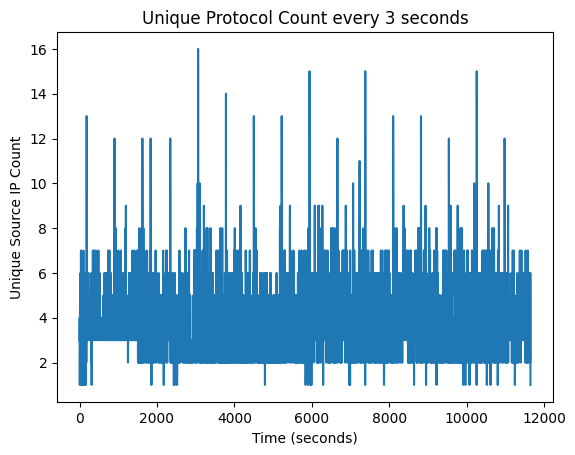

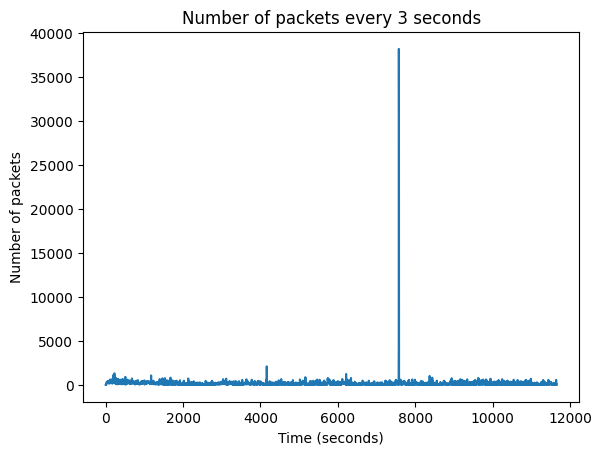

In [6]:
# Make figure with 4 rows of plots
#fig, plots = plt.subplots(4, 1)
#fig.suptitle('DARPA 2000 Internal Tuesday, 7 March 2000, from 9:25 AM to 12:35 PM', fontsize=16)
plt.plot(unique_source_count.index.seconds, unique_source_count.Source)
plt.title("Unique Source IP Address Count every 3 seconds")
plt.xlabel("Time (seconds)")
plt.ylabel("Unique Source IP Count")
plt.show()

plt.plot(unique_destination_count.index.seconds, unique_destination_count.Destination)
plt.title("Unique Destination IP Address Count every 3 seconds")
plt.xlabel("Time (seconds)")
plt.ylabel("Unique Destination IP Count")
plt.show()

plt.plot(unique_protocol_count.index.seconds, unique_protocol_count.Protocol)
plt.title("Unique Protocol Count every 3 seconds")
plt.xlabel("Time (seconds)")
plt.ylabel("Unique Source IP Count")
plt.show()

plt.plot(packets_count.index.seconds, packets_count['No.'])
plt.title("Number of packets every 3 seconds")
plt.xlabel("Time (seconds)")
plt.ylabel("Number of packets")
plt.show()

#fig.tight_layout()

### Plot A1, A2, A3, A4

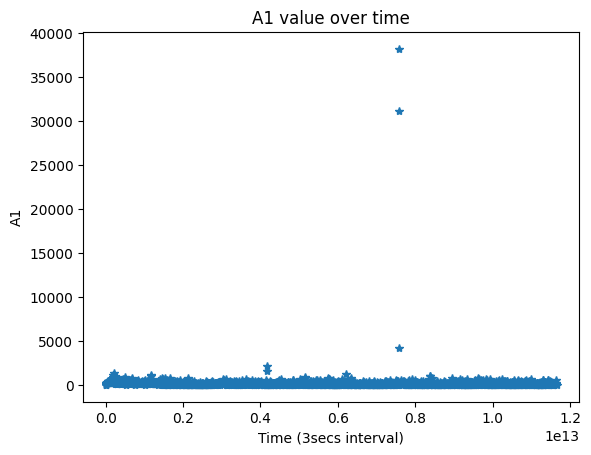

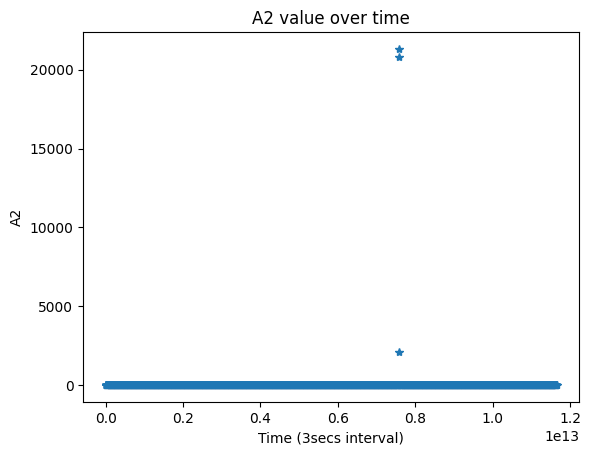

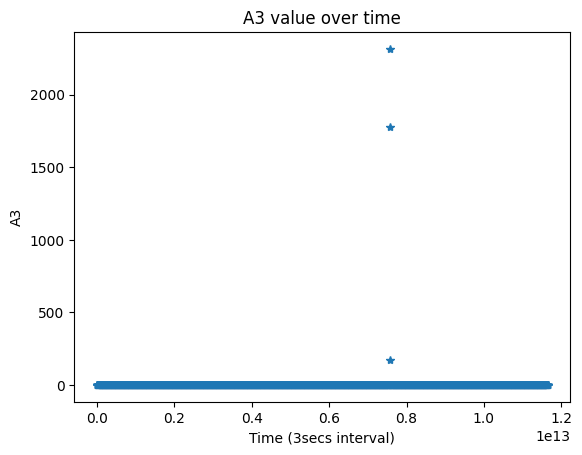

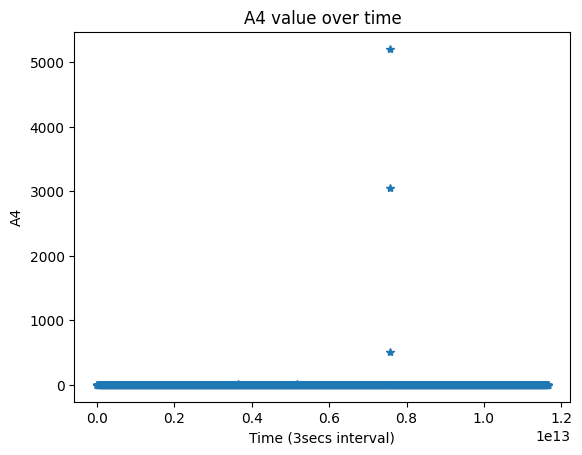

In [7]:
##ye = packets_count.iloc[2426:2526, 0].to_list()
##print(ye)
#print(packets_count.loc[packets_count['No.'].idxmax()])
# data => 38215
# second => 7575 => 2525
# Timedelta => 0 days 02:06:15

A1_all = packets_count
A2_all = unique_source_count
A3_all = unique_source_count['Source'].divide(unique_destination_count['Destination']).to_frame()
A4_all = unique_source_count['Source'].divide(unique_protocol_count['Protocol']).to_frame()

plt.plot(A1_all, '*')
#plt.plot(A1_all.iloc[:, 0].to_list())
plt.title("A1 value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("A1")
plt.show()

plt.plot(A2_all, '*')
#plt.plot(A2_all.iloc[:, 0].to_list())
plt.title("A2 value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("A2")
plt.show()

plt.plot(A3_all, '*')
#plt.plot(A3_all.iloc[:, 0].to_list())
plt.title("A3 value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("A3")
plt.show()

plt.plot(A4_all, '*')
#plt.plot(A4_all.iloc[:, 0].to_list())
plt.title("A4 value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("A4")
plt.show()


In [8]:
A_all = (A1_all, A2_all, A3_all, A4_all)
Threshold_all = []
N_all = []
beta_all = []

j_to_end = range(len(A1_all.iloc[:, 0].to_list()))

for A in A_all:
    # Init values
    K = 1
    beta = 1.5
    j = 0
    T = 3
    current_threshold_array = list()
    current_N_array = list()
    current_beta_array = list()

    current_moving_A = A.iloc[j: j+K, 0].to_list()
    current_moving_mean = np.mean(current_moving_A)
    current_moving_variance = np.var(current_moving_A)
    current_threshold = (current_moving_mean + current_moving_variance) * beta

    current_threshold_array.append([j, current_threshold])
    current_beta_array.append([j, beta])

    #while j <= K*T-1 and j < len(A1_all.iloc[:, 0].to_list()):
    while j < len(A1_all.iloc[:, 0].to_list()):
        if j < 0 and j % K*T == 0:
            beta = 1.5
            current_moving_A = A.iloc[j: j+K, 0].to_list()
            current_moving_mean = np.mean(current_moving_A)
            current_moving_variance = np.var(current_moving_A)
            current_threshold = (current_moving_mean + current_moving_variance) * beta

            current_threshold_array.append([j, current_threshold])
            current_beta_array.append([j, beta])
        else:
            if A.iloc[j:j+1, 0].to_list()[0] > current_threshold:
                current_N_array.append([j, True])
            else:
                current_N_array.append([j, False])
            j = j + 1
            current_j = j
            previous_j = j - 1
            previous_moving_mean = np.mean(A.iloc[previous_j: previous_j+K, 0].to_list())
            current_moving_mean = np.mean(A.iloc[current_j: current_j+K, 0].to_list())
            if current_moving_mean > 2 * previous_moving_mean:
                beta = beta + 0.5
                current_threshold = (current_moving_mean + np.var(A.iloc[current_j: current_j+K, 0].to_list())) * beta
            else:
                beta = beta - 0.5
                if beta < 1.0:
                    beta = 1
                current_threshold = (current_moving_mean + np.var(A.iloc[current_j: current_j+K, 0].to_list())) / beta
            current_threshold_array.append([current_j, current_threshold])
            current_beta_array.append([j, beta])

    Threshold_all.append(current_threshold_array)
    N_all.append(current_N_array)
    beta_all.append(current_beta_array)



#print(beta_all)
#print(Threshold_all)
#print(N_all)

/home/yoffa/codebase/PycharmProjects/darpa2k/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yoffa/codebase/PycharmProjects/darpa2k/venv/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yoffa/codebase/PycharmProjects/darpa2k/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yoffa/codebase/PycharmProjects/darpa2k/venv/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yoffa/codebase/PycharmProjects/darpa2k/venv/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid valu

### Nilai Threshold berubah tiap waktu

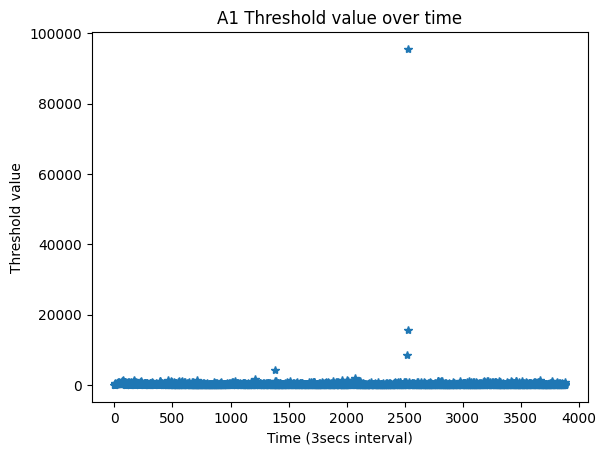

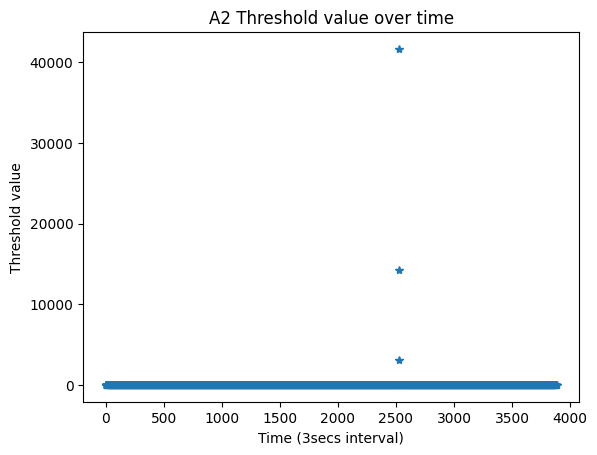

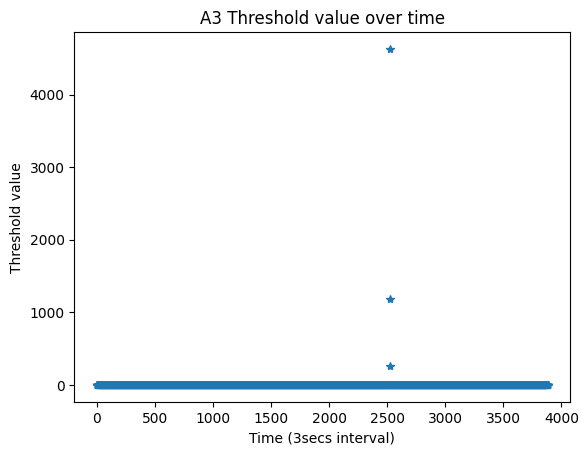

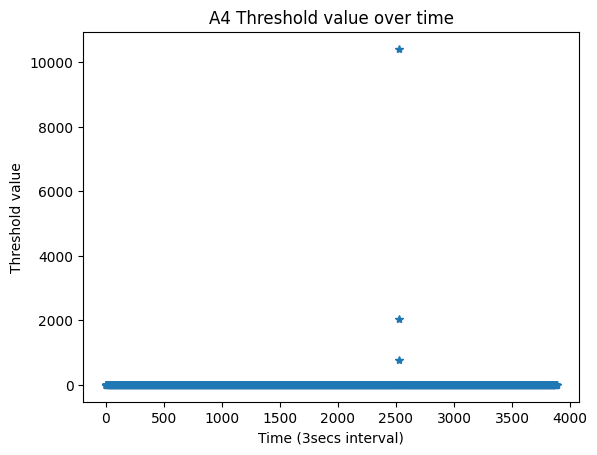

In [9]:
beta1y = list()
beta2y = list()
beta3y = list()
beta4y = list()

for betaXY in Threshold_all[0]:
    beta1y.append(betaXY[1])

for betaXY in Threshold_all[1]:
    beta2y.append(betaXY[1])

for betaXY in Threshold_all[2]:
    beta3y.append(betaXY[1])

for betaXY in Threshold_all[3]:
    beta4y.append(betaXY[1])

plt.plot(beta1y, '*')
#plt.plot(A1_all.iloc[:, 0].to_list())
plt.title("A1 Threshold value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Threshold value")
plt.show()

plt.plot(beta2y, '*')
#plt.plot(A2_all.iloc[:, 0].to_list())
plt.title("A2 Threshold value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Threshold value")
plt.show()

plt.plot(beta3y, '*')
#plt.plot(A3_all.iloc[:, 0].to_list())
plt.title("A3 Threshold value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Threshold value")
plt.show()

plt.plot(beta4y, '*')
#plt.plot(A4_all.iloc[:, 0].to_list())
plt.title("A4 Threshold value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Threshold value")
plt.show()

### Nature of Network tiap waktu
Jika 1 maka deteksi positif, jika 0 maka normal

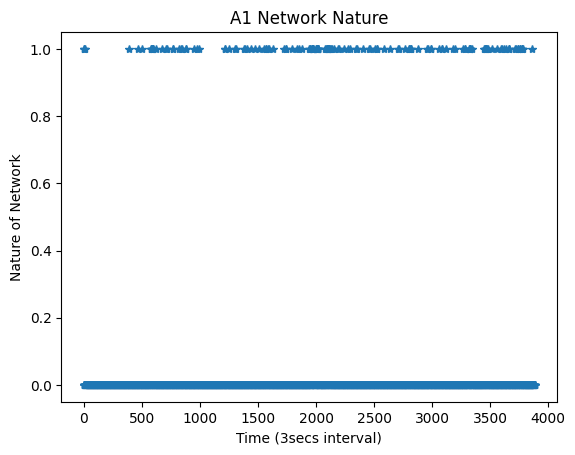

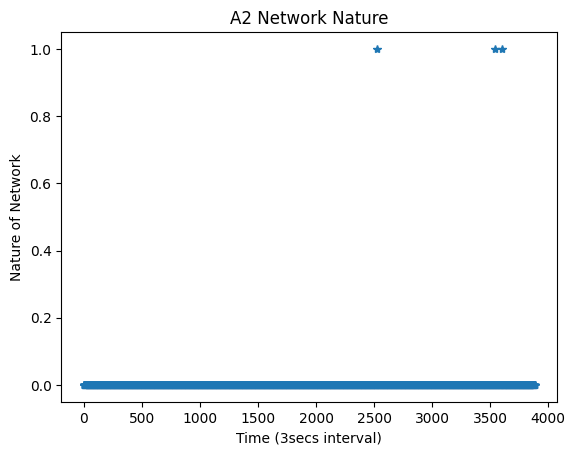

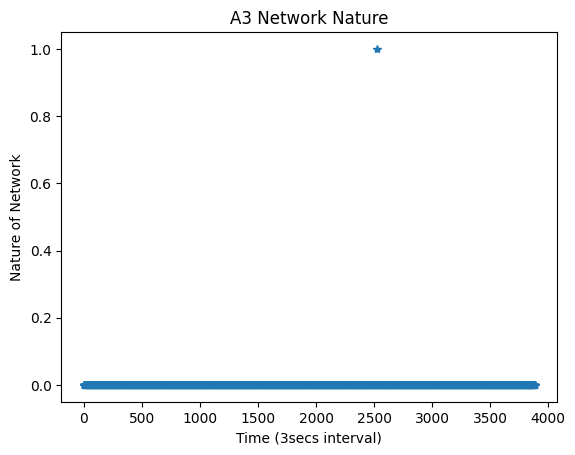

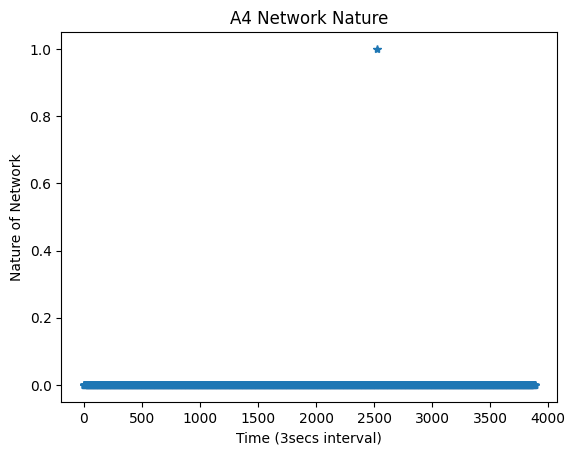

In [10]:
beta1y = list()
beta2y = list()
beta3y = list()
beta4y = list()

for betaXY in N_all[0]:
    beta1y.append(betaXY[1])

for betaXY in N_all[1]:
    beta2y.append(betaXY[1])

for betaXY in N_all[2]:
    beta3y.append(betaXY[1])

for betaXY in N_all[3]:
    beta4y.append(betaXY[1])

plt.plot(beta1y, '*')
#plt.plot(A1_all.iloc[:, 0].to_list())
plt.title("A1 Network Nature")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Nature of Network")
plt.show()

plt.plot(beta2y, '*')
#plt.plot(A2_all.iloc[:, 0].to_list())
plt.title("A2 Network Nature")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Nature of Network")
plt.show()

plt.plot(beta3y, '*')
#plt.plot(A3_all.iloc[:, 0].to_list())
plt.title("A3 Network Nature")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Nature of Network")
plt.show()

plt.plot(beta4y, '*')
#plt.plot(A4_all.iloc[:, 0].to_list())
plt.title("A4 Network Nature")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Nature of Network")
plt.show()


In [11]:
N_for_testing = []

for idx in j_to_end:
    if N_all[0][idx][1] is True and N_all[1][idx][1] is True and N_all[2][idx][1] is True and N_all[3][idx][1] is True:
        N_for_testing.append(1)
    else:
        N_for_testing.append(0)


In [12]:
A1_all['real'] = 0
A1_all.head()

pckts = packets_count.iloc[2525:2528, 0].index
pckts

TimedeltaIndex(['0 days 02:06:15', '0 days 02:06:18', '0 days 02:06:21'], dtype='timedelta64[ns]', name='T', freq='3S')

In [13]:
A1_all.at['0 days 02:06:15', 'real'] = 1
A1_all.at['0 days 02:06:18', 'real'] = 1
A1_all.at['0 days 02:06:21', 'real'] = 1

In [14]:
y_real = A1_all.iloc[:, 1].to_list()

In [15]:
y_pred = N_for_testing

In [16]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return TP, FP, TN, FN

def sensitivity(true_positive, false_negative):
    return true_positive / (true_positive + false_negative)

def accuracy(true_positive, false_positive, true_negative, false_negative):
    return (true_positive + true_negative) / (true_positive + false_positive + true_negative + false_negative)

def specificity(true_negative, false_positive):
    return true_negative / (true_negative + false_positive)

def precision(true_positive, false_positive):
    return true_positive / (true_positive + false_positive)

In [17]:
tp, fp, tn, fn = perf_measure(y_real, y_pred)

print(
    "\ntrue positive: {}".format(tp),
    "\nfalse positive: {}".format(fp),
    "\ntrue negative: {}".format(tn),
    "\nfalse negative: {}".format(fn)
)

print("\n")

print("Sensitivity (TPR): {}".format(sensitivity(tp, fn)))
print("Accuracy: {}".format(accuracy(tp, fp, tn, fn)))
print("Specificity (TNR): {}".format(specificity(tn, fp)))
print("Precision: {}".format(precision(tp, fp)))


true positive: 1 
false positive: 0 
true negative: 3882 
false negative: 2


Sensitivity (TPR): 0.3333333333333333
Accuracy: 0.9994851994851995
Specificity (TNR): 1.0
Precision: 1.0


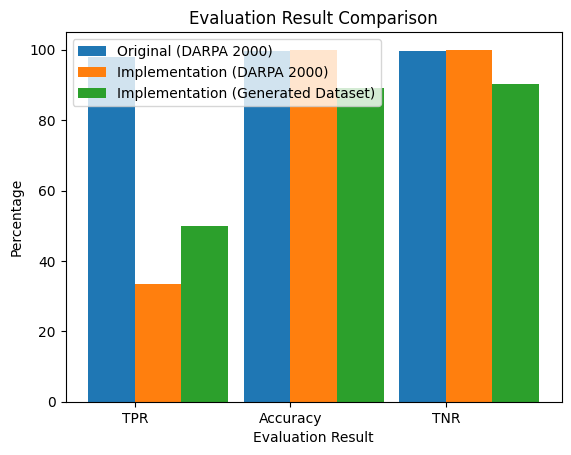

In [18]:
david_j = [98, 99.5, 99.6]
mine = [33.33, 99.94, 100]
generated_result = [50, 89.15, 90.12]

index = np.arange(3)
bar_width = 0.3

fig, ax = plt.subplots()
original = ax.bar(index, david_j, bar_width,
                label="Original (DARPA 2000)")

implementation = ax.bar(index+bar_width, mine,
                 bar_width, label="Implementation (DARPA 2000)")

generated = ax.bar(index+2*bar_width, generated_result, bar_width, label="Implementation (Generated Dataset)")

ax.set_xlabel('Evaluation Result')
ax.set_ylabel('Percentage')
ax.set_title('Evaluation Result Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(["TPR", "Accuracy", "TNR"])
ax.legend()

plt.show()